In [82]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [83]:
df = pd.read_csv('customer_churn.csv')
# df.shape (7043, 21)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [84]:
df.info() # TotalCharges имеет тип object вместо float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [85]:
print(df['TotalCharges'].unique()[:10])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
print(f"Тип данных после обработки: {df['TotalCharges'].dtype}")

['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']
Тип данных после обработки: float64


In [86]:
conn = sqlite3.connect(':memory:')
df.to_sql('customer', conn)

# Запрос 1: Демография уходящих клиентов
q1 = """
SELECT
    gender,
    SeniorCitizen,
    Partner,
    Dependents,
    COUNT(*) as total_customers,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) as churn_rate
FROM customer
GROUP BY gender, SeniorCitizen, Partner, Dependents
ORDER BY churn_rate DESC;
"""
demo_churn = pd.read_sql_query(q1, conn)
print("Демография оттока:")
demo_churn

Демография оттока:


,gender,SeniorCitizen,Partner,Dependents,total_customers,churn_rate
0,Female,1,No,No,317,49.84
1,Male,1,No,No,244,48.36
2,Male,1,Yes,No,281,37.37
3,Female,1,Yes,No,209,34.93
4,Female,1,No,Yes,3,33.33
5,Female,0,No,No,1338,32.06
6,Male,0,No,No,1381,30.27
7,Male,1,Yes,Yes,44,27.27
8,Male,0,Yes,No,567,22.57
9,Female,0,No,Yes,142,22.54


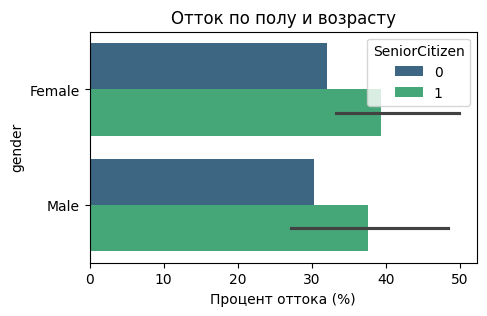

In [87]:
# Отток по полу и возрасту
plt.figure(figsize=(5, 3))
sns.barplot(data=demo_churn.head(8), x='churn_rate', y='gender',
            hue='SeniorCitizen', palette='viridis')
plt.title('Отток по полу и возрасту')
plt.xlabel('Процент оттока (%)')
plt.show()

In [88]:
# Запрос 2: Поведенческие паттерны (услуги)
q2 = """
SELECT
    InternetService,
    Contract,
    PaperlessBilling,
    PaymentMethod,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) as churn_rate,
    COUNT(*) as count
FROM customer
GROUP BY InternetService, Contract, PaperlessBilling, PaymentMethod
HAVING count > 50
ORDER BY churn_rate DESC;
"""
behavior_churn = pd.read_sql_query(q2, conn)
print("Поведенческие паттерны оттока:")
behavior_churn


Поведенческие паттерны оттока:


,InternetService,Contract,PaperlessBilling,PaymentMethod,churn_rate,count
0,Fiber optic,Month-to-month,Yes,Electronic check,62.92,1060
1,Fiber optic,Month-to-month,Yes,Mailed check,53.15,143
2,Fiber optic,Month-to-month,No,Electronic check,49.39,247
3,Fiber optic,Month-to-month,Yes,Bank transfer (automatic),47.39,249
4,Fiber optic,Month-to-month,No,Mailed check,44.83,58
5,DSL,Month-to-month,Yes,Electronic check,43.42,304
6,Fiber optic,Month-to-month,Yes,Credit card (automatic),42.62,237
7,Fiber optic,Month-to-month,No,Bank transfer (automatic),39.74,78
8,Fiber optic,Month-to-month,No,Credit card (automatic),37.50,56
9,DSL,Month-to-month,No,Electronic check,35.29,170


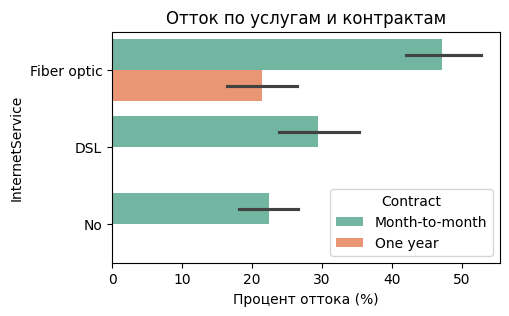

In [89]:
# Отток по типу интернета и контракту
plt.figure(figsize=(5, 3))
sns.barplot(data=behavior_churn.head(20), x='churn_rate', y='InternetService',
            hue='Contract', palette='Set2')
plt.title('Отток по услугам и контрактам')
plt.xlabel('Процент оттока (%)')
plt.show()

**ТОП-5 самых рискованных сегментов:**
1. Fiber optic + Month-to-month + Electronic check: 63% оттока
2. Fiber optic + Month-to-month + Mailed check: 53%  
3. Fiber optic + Month-to-month + Bank transfer: 47%
4. DSL + Month-to-month + Electronic check: 43%
5. Пенсионеры без семьи: ~49% оттока




In [90]:
# предобработка данных для ML
df_ml = df.copy()

df_ml.drop(['customerID'], axis=1, inplace=True)
df_ml['Churn'] = df_ml['Churn'].map({'Yes': 1, 'No': 0})

# One-Hot Encoding
categorical_cols = df_ml.select_dtypes(include=['object']).columns.tolist()
df_ml = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)

# Разделение данных
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [91]:
# Обучаю Random Forest и Logistic Regression
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")



Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8414

Random Forest
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.50      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409

ROC-AUC: 0.8253


In [110]:
# Далее испольую лучшую модель - логистическую регрессию
best_model = LogisticRegression(random_state=42, max_iter=1000)
best_model.fit(X_train_scaled, y_train)

# Вероятности оттока для всех клиентов
X_all_customers = scaler.transform(X)
df_with_predictions = df.copy()
df_with_predictions['Churn_Probability'] = best_model.predict_proba(X_all_customers)[:, 1]

# Уровень риска для каждого клиента
def get_risk_level(probability):
    if probability < 0.2:
        return 'Low Risk'
    elif probability < 0.5:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_with_predictions['Risk_Level'] = df_with_predictions['Churn_Probability'].apply(get_risk_level)

print(f"\nЭффективность сегментации:")
for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    segment_data = df_with_predictions[df_with_predictions['Risk_Level'] == risk_level]
    actual_churn_rate = (segment_data['Churn'] == 'Yes').mean() * 100
    avg_probability = segment_data['Churn_Probability'].mean() * 100
    print(f"{risk_level}: {len(segment_data):4d} клиентов | Реальный отток: {actual_churn_rate:5.1f}% | Средняя вероятность: {avg_probability:5.1f}%")

print(f"\nСегментация эффективна: модель точно определяет группы риска")


Эффективность сегментации:
Low Risk: 3654 клиентов | Реальный отток:   7.2% | Средняя вероятность:   6.6%
Medium Risk: 1822 клиентов | Реальный отток:  31.3% | Средняя вероятность:  33.7%
High Risk: 1567 клиентов | Реальный отток:  66.2% | Средняя вероятность:  64.8%

Сегментация эффективна: модель точно определяет группы риска


In [108]:
# Финансовый анализ
high_risk_customers = df_with_predictions[df_with_predictions['Risk_Level'] == 'High Risk']
monthly_revenue_at_risk = high_risk_customers['MonthlyCharges'].sum()

print(f"ФИНАНСОВЫЙ АНАЛИЗ:")
print(f"Клиенты высокого риска приносят: {monthly_revenue_at_risk:,.0f}$ в месяц")
print(f"Потенциальная годовая потеря: {monthly_revenue_at_risk * 12:,.0f}$")

# Анализ самых рискованных групп
print(f"\nСАМЫЕ РИСКОВЫЕ ГРУППЫ:")
top_groups = high_risk_customers.groupby(['Contract', 'InternetService']).size().nlargest(2)
for i, (combo, count) in enumerate(top_groups.items(), 1):
    contract, internet = combo
    print(f"{i}. {contract} + {internet}: {count} клиентов")

# Финансовое воздействие по группам
print(f"\nФИНАНСОВОЕ ВОЗДЕЙСТВИЕ:")
for combo, count in top_groups.items():
    contract, internet = combo
    group_revenue = high_risk_customers[
        (high_risk_customers['Contract'] == contract) &
        (high_risk_customers['InternetService'] == internet)
    ]['MonthlyCharges'].sum()
    print(f"{contract} + {internet}: {group_revenue:,.0f}$/месяц")

print(f"\n💡 РЕКОМЕНДАЦИИ:")
print(f"1. Срочные меры для {len(high_risk_customers)} клиентов высокого риска")
print(f"2. A/B тест: предложить скидку 20% на переход на годовой контракт")
print(f"3. Персональные предложения для клиентов с Fiber optic + Month-to-month")

ФИНАНСОВЫЙ АНАЛИЗ:
Клиенты высокого риска приносят: 126,546$ в месяц
Потенциальная годовая потеря: 1,518,546$

САМЫЕ РИСКОВЫЕ ГРУППЫ:
1. Month-to-month + Fiber optic: 1390 клиентов
2. Month-to-month + DSL: 176 клиентов

ФИНАНСОВОЕ ВОЗДЕЙСТВИЕ:
Month-to-month + Fiber optic: 119,072$/месяц
Month-to-month + DSL: 7,383$/месяц

💡 РЕКОМЕНДАЦИИ:
1. Срочные меры для 1567 клиентов высокого риска
2. A/B тест: предложить скидку 20% на переход на годовой контракт
3. Персональные предложения для клиентов с Fiber optic + Month-to-month


In [112]:
import joblib

# Сохранение модели и scaler
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Сохранение названий признаков
import json
with open('feature_names.json', 'w') as f:
    json.dump(X_train.columns.tolist(), f)

print("Модель, scaler и feature names сохранены!")

Модель, scaler и feature names сохранены!
